In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import meshplot as mp
import gudhi                 as gd
from tqdm                    import tqdm
from sklearn.cluster import KMeans, AgglomerativeClustering
from mapper import MapperComplex
from SoftMapper import smooth_scheme, compute_mapper, filter_extended_st
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline
from scipy.spatial.distance import directed_hausdorff
from scipy.stats import bernoulli
import matplotlib as mpl
from pyvis.network import Network

In [2]:
import wot

In [3]:
data = wot.io.read_dataset(r"Datasets/data/ExprMatrix.h5ad")

In [4]:
days_df = pd.read_csv(r"Datasets/data/cell_days.txt", index_col='id', sep='\t')
days_df

,day
id,
D0_Dox_C1_AAACCTGAGTATCTCG-1,0.0
D0_Dox_C1_AAACCTGCAAGCGAGT-1,0.0
D0_Dox_C1_AAACCTGGTCTCTTAT-1,0.0
D0_Dox_C1_AAACCTGTCAACACTG-1,0.0
D0_Dox_C1_AAACCTGTCGTTGCCT-1,0.0
...,...
D18_serum_C2_TTTGGTTTCTTATCTG-1,18.0
D18_serum_C2_TTTGTCAAGATTACCC-1,18.0
D18_serum_C2_TTTGTCAAGTGAACAT-1,18.0


In [5]:
names=list(days_df.index)

labels=[name.split('_')[1] for name in names]

x=data._X[:days_df.shape[0],:]

In [6]:
x.shape

(236285, 19089)

In [7]:
# take a subsample of the data
np.random.seed(0)
subsample=np.random.choice(range(x.shape[0]), size=1500)
X=x[subsample,:]

In [8]:
# pre-process data
B=np.repeat(np.sum(X,axis=1),x.shape[1],axis=1)

X=np.log1p(X*10000/B)

In [9]:
time=list(np.array(days_df)[subsample,:].ravel())

In [10]:
labels=np.array(labels)[subsample]

In [11]:
n,p=X.shape

In [12]:
X=X.toarray()

## Linear filter

In [13]:
np.random.seed(1)
subset=np.random.randint(low=0,high=len(time),size=500)
delta=np.max([directed_hausdorff(X,X[subset,:]),directed_hausdorff(X[subset,:],X)])

In [14]:
delta

1320.0

In [15]:

resolutions=np.array([25])
gain=np.array([0.3])
sigma=1e-5

ag=AgglomerativeClustering(n_clusters=None,distance_threshold=1e-1*delta)

params=tf.Variable(initial_value=np.ones((p,1)).astype(np.float32)/np.sqrt(p),trainable=True)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=5e-2, decay_steps=10, decay_rate=0.1)
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

2024-02-08 16:16:07.037333: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-08 16:16:07.038365: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-08 16:16:07.038375: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-08 16:16:07.038617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-08 16:16:07.039208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
f=tf.tensordot(X.astype(np.float32),params,axes=1)
mapper=MapperComplex(colors=np.array(time).reshape((-1,1)),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis()
nt.show('sc_ot_initial.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [17]:
losses = []
K=10
with Parallel(n_jobs=-1) as parallel:
    for epoch in tqdm(range(300+1)):

        f=tf.tensordot(X.astype(np.float32),params,axes=1)
        fn=(f-tf.math.reduce_min(f))/(tf.math.reduce_max(f)-tf.math.reduce_min(f))
        scheme=smooth_scheme(fn.numpy(),resolutions,gain,sigma)

        upscheme=np.repeat(scheme,K,axis=0)

        assignments=bernoulli.rvs(upscheme,random_state=0)

        st,clusters=compute_mapper(X,ag,assignments,maximum=5)
        
        with tf.GradientTape() as tape:
            f=tf.tensordot(X.astype(np.float32),params,axes=1)
            f_values=tf.repeat(tf.expand_dims(f,axis=0),clusters.shape[0],axis=0)

            f_values=tf.repeat(f_values,clusters.shape[2],axis=2)

            filtration=tf.math.reduce_sum(f_values*clusters,axis=1)/(np.sum(clusters,axis=1)+1e-10)
            #l=[(_LowerStarSimplexTree(st[k],filtration[k],[0],11,False)[0][0]).reshape(-1,2) for k in range(n)]
            l=parallel(delayed(filter_extended_st)(list(st[k].get_skeleton(1)),filtration.numpy()[k]) 
                for k in range(K))
            loss=0
            
            #dgm=tf.concat([tf.gather(filtration[k],l[k]) for k in range(K)],axis=0)
            for k in range(K):
                dgm=tf.gather(filtration[k],l[k]) 
                loss=loss-tf.math.reduce_sum(tf.math.abs((dgm[:,1]-dgm[:,0])))/K

            regularization = tf.math.square(tf.norm(params)-1)

            loss=loss+regularization

        gradients = tape.gradient(loss, [params])
        
        optimizer.apply_gradients(zip(gradients, [params]))


        losses.append(loss.numpy())

100%|█████████████████████████████████████████| 301/301 [52:12<00:00, 10.41s/it]


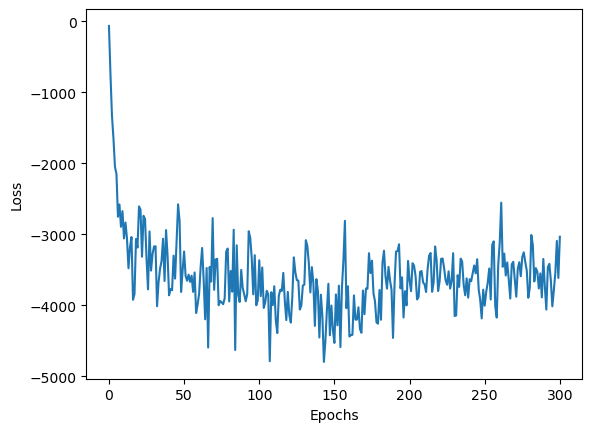

In [18]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [19]:
tf.norm(params)

<tf.Tensor: shape=(), dtype=float32, numpy=59.924488>

In [20]:
mapper=MapperComplex(colors=np.array(time).reshape((-1,1)),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis()
nt.show('sc_ot_final.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [21]:
mapper=MapperComplex(colors=(labels=='Dox').astype(np.int32).reshape(-1,1),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis(cmap=cm.hot)
nt.show('sc_ot_dox.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [22]:
mapper=MapperComplex(colors=(labels=='2i').astype(np.int32).reshape(-1,1),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis(cmap=cm.hot)
nt.show('sc_ot_2i.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [23]:
mapper=MapperComplex(colors=(labels=='serum').astype(np.int32).reshape(-1,1),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis(cmap=cm.hot)
nt.show('sc_ot_serum.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()
lab=ohe.fit_transform(labels.reshape(-1, 1))

In [35]:


channels=np.stack([np.mean(lab.toarray()[v['indices'],:],axis=0) for v in mapper.node_info.values()])

#norm0 = mpl.colors.Normalize(vmin=np.min(channels[:,0]), vmax=np.max(channels[:,0]))
#m0 = cm.ScalarMappable(norm=norm0,  cmap=cm.Blues)

#norm1 = mpl.colors.Normalize(vmin=np.min(channels[:,1]), vmax=np.max(channels[:,1]))
#m1 = cm.ScalarMappable(norm=norm1,  cmap=cm.Reds)

#norm2 = mpl.colors.Normalize(vmin=np.min(channels[:,2]), vmax=np.max(channels[:,2]))
#m2 = cm.ScalarMappable(norm=norm2,  cmap=cm.Greens)

def to_hex(color):
    return '#'+''.join(["%02x" % e for e in color])

nt = Network('500px', '500px',notebook=True, directed=False)
st = mapper.simplex_tree

#color=(m0.to_rgba(channels[:,0],bytes=True)[:,:3]+m1.to_rgba(channels[:,1],bytes=True)[:,:3]+
#       m2.to_rgba(channels[:,2],bytes=True)[:,:3])/3

color=channels*255

for (splx,_) in st.get_skeleton(0):
    nt.add_node(splx[0],color=to_hex(color[splx[0],:].astype(int)))
for (splx,_) in st.get_skeleton(1):
    if len(splx) == 2:
        nt.add_edge(splx[1], splx[0])
        
nt.show('phases.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
